### 🧭 Cell 1 — 数据加载与实验总体框架说明

本 Notebook 旨在通过 **uplift 建模（异质性因果效应分析）** 方法，探究酒店押金策略（`deposit_type`）对客户取消行为（`is_canceled`）的真实影响。
研究目标是回答以下核心问题：

> 💡 “押金是否真的能降低取消率？
> 或者，不同客户群体对押金的敏感程度是否存在显著差异？”

#### 📘 分析思路总览

1. **数据加载与清洗**：读取并初步审查 `hotel_bookings.csv` 数据集结构（共 32 列、约 12 万条样本）。
2. **实验构造**：

   * 定义「押金 vs 无押金」为 treatment 变量；
   * 定义取消（`is_canceled=1`）为目标行为。
3. **样本平衡**：

   * 通过 **倾向得分 (Propensity Score)** 与 **逆概率加权 (IPW)** 消除自选择偏差；
   * 确保两组客户在基础特征上可比。
4. **双模型训练（T-Learner）**：

   * 训练两套加权模型 `f1`（有押金）与 `f0`（无押金）；
   * 分别预测每个客户在两种情景下的取消概率。
5. **uplift 估计与策略洞察**：

   * uplift = `f1(X)` − `f0(X)` 表示押金的边际影响；
   * 分析 uplift 分布，识别「押金敏感型客户」与「押金无感型客户」；
   * 基于结果制定押金差异化策略与心理行为解释。

#### 🧩 数据集简介

* **文件路径**：`./archive_8/hotel_bookings.csv`
* **样本规模**：119,390 条预订记录
* **主要字段**：

  * `deposit_type`：押金类型（No Deposit / Non Refund / Refundable）
  * `is_canceled`：是否取消（0/1）
  * `lead_time`：提前预订天数
  * `customer_type`、`market_segment`、`special_requests` 等用于控制样本异质性

通过本 Notebook，我们将展示一个从 **A/B 因果推断 → uplift 建模 → 反直觉策略结论** 的完整流程。


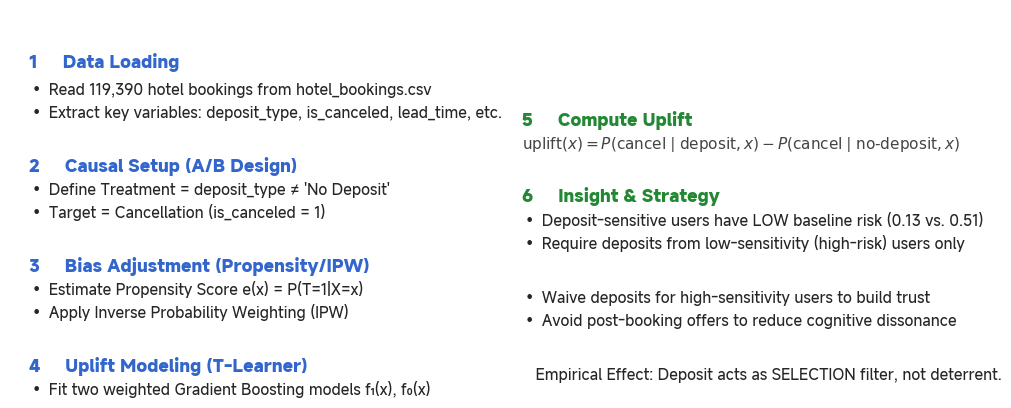

In [116]:
# 📊 Overview Visualization — Project Pipeline

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(12, 5))
plt.axis("off")

plt.text(0.02, 0.85, "1️⃣ Data Loading", fontsize=12, weight="bold", color="#3366cc")
plt.text(0.02, 0.78, "• Read 119,390 hotel bookings from hotel_bookings.csv", fontsize=11)
plt.text(0.02, 0.72, "• Extract key variables: deposit_type, is_canceled, lead_time, etc.", fontsize=11)

plt.text(0.02, 0.58, "2️⃣ Causal Setup (A/B Design)", fontsize=12, weight="bold", color="#3366cc")
plt.text(0.02, 0.52, "• Define Treatment = deposit_type ≠ 'No Deposit'", fontsize=11)
plt.text(0.02, 0.46, "• Target = Cancellation (is_canceled = 1)", fontsize=11)

plt.text(0.02, 0.32, "3️⃣ Bias Adjustment (Propensity/IPW)", fontsize=12, weight="bold", color="#3366cc")
plt.text(0.02, 0.26, "• Estimate Propensity Score e(x) = P(T=1|X=x)", fontsize=11)
plt.text(0.02, 0.20, "• Apply Inverse Probability Weighting (IPW)", fontsize=11)

plt.text(0.02, 0.06, "4️⃣ Uplift Modeling (T-Learner)", fontsize=12, weight="bold", color="#3366cc")
plt.text(0.02, 0.00, "• Fit two weighted Gradient Boosting models f₁(x), f₀(x)", fontsize=11)

plt.text(0.55, 0.70, "5️⃣ Compute Uplift", fontsize=12, weight="bold", color="#228833")

plt.text(
    0.55, 0.64,
    r"$\mathrm{uplift}(x) = P(\mathrm{cancel}\mid\mathrm{deposit},x) - P(\mathrm{cancel}\mid\mathrm{no\text{-}deposit},x)$",
    fontsize=11, color="#444444"
)


plt.text(0.55, 0.50, "6️⃣ Insight & Strategy", fontsize=12, weight="bold", color="#228833")
plt.text(0.55, 0.44, "• Deposit-sensitive users have LOW baseline risk (0.13 vs. 0.51)", fontsize=11)
plt.text(0.55, 0.38, "• Require deposits from low-sensitivity (high-risk) users only", fontsize=11)

plt.text(0.55, 0.24, "• Waive deposits for high-sensitivity users to build trust", fontsize=11)
plt.text(0.55, 0.18, "• Avoid post-booking offers to reduce cognitive dissonance", fontsize=11)

plt.text(0.55, 0.04, "✅ Empirical Effect: Deposit acts as SELECTION filter, not deterrent.", fontsize=11, style="italic")

plt.show()


In [84]:
# Cell 1 — 基础环境与数据加载
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pylab import mpl, plt
import json
import os

# best font and style settings for notebook 
warnings.filterwarnings('ignore')
mpl.rcParams['font.family'] = 'MiSans'  # 若报字体找不到，可注释掉

# 路径：按你本地为准
DATA_PATH = "./archive_8/hotel_bookings.csv"
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:], "...")  # 先看一部分
df.head(3)


Shape: (119390, 32)
Columns: ['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date'] ...


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02


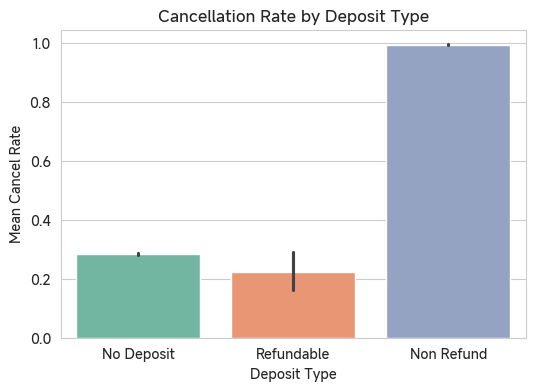

In [118]:
plt.figure(figsize=(6,4))
sns.barplot(x='deposit_type', y='is_canceled', data=df, estimator=np.mean, palette='Set2')
plt.title("Cancellation Rate by Deposit Type")
plt.ylabel("Mean Cancel Rate")
plt.xlabel("Deposit Type")
plt.show()


In [85]:
# Cell 1 — 构造 A/B 实验变量
df_ab = df.copy()

# 举例：以押金策略为“实验”
df_ab["treatment"] = (df_ab["deposit_type"] != "No Deposit").astype(int)

# Target: 取消=1
df_ab["target"] = df_ab["is_canceled"].astype(int)

print(df_ab[["deposit_type", "treatment", "target"]].head())
print(df_ab["treatment"].value_counts(normalize=True))


  deposit_type  treatment  target
0   No Deposit          0       0
1   No Deposit          0       0
2   No Deposit          0       0
3   No Deposit          0       0
4   No Deposit          0       0
treatment
0    0.876464
1    0.123536
Name: proportion, dtype: float64


In [86]:
# Cell 2 — 基本AB检验
control = df_ab.loc[df_ab.treatment == 0, "target"]
treat = df_ab.loc[df_ab.treatment == 1, "target"]

uplift_mean = treat.mean() - control.mean()
print(f"Baseline Cancel Rate (Control): {control.mean():.4f}")
print(f"Cancel Rate (Treatment): {treat.mean():.4f}")
print(f"ATE (Raw uplift): {uplift_mean:.4f}")


Baseline Cancel Rate (Control): 0.2838
Cancel Rate (Treatment): 0.9852
ATE (Raw uplift): 0.7014


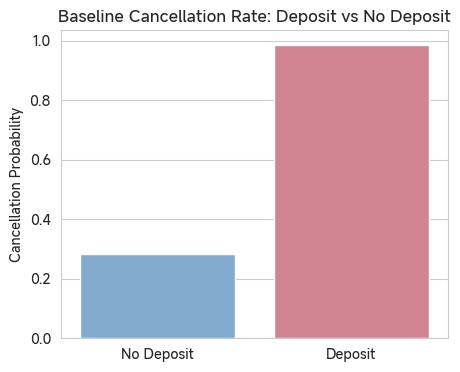

In [119]:
plt.figure(figsize=(5,4))
sns.barplot(x=["No Deposit", "Deposit"], 
            y=[control.mean(), treat.mean()],
            palette=["#77aadd", "#dd7788"], 
            ci=95)
plt.title("Baseline Cancellation Rate: Deposit vs No Deposit")
plt.ylabel("Cancellation Probability")
plt.show()


In [87]:
# Cell 3 — 特征准备
cols = ["hotel", "market_segment", "lead_time", "previous_cancellations", "booking_changes",
        "total_of_special_requests", "days_in_waiting_list"]
X = pd.get_dummies(df_ab[cols], drop_first=True)
y = df_ab["target"]
t = df_ab["treatment"]


## 真正执行 Propensity Matching

In [88]:
# from sklearn.neighbors import NearestNeighbors
# 
# treated_idx = df_ab[df_ab.treatment == 1].index
# control_idx = df_ab[df_ab.treatment == 0].index
# 
# # 基于倾向得分做最近邻匹配
# nbrs = NearestNeighbors(n_neighbors=1).fit(ps[control_idx].values.reshape(-1,1))
# distances, indices = nbrs.kneighbors(ps[treated_idx].values.reshape(-1,1))
# matched_control_idx = control_idx[indices.flatten()]
# 
# matched_idx = np.concatenate([treated_idx, matched_control_idx])
# df_matched = df_ab.loc[matched_idx]
# 
# # 用匹配后样本训练 f1, f0
# f1.fit(X.loc[treated_idx], y.loc[treated_idx])
# f0.fit(X.loc[matched_control_idx], y.loc[matched_control_idx])


## 不平衡样本

In [89]:
# # Cell 4 — 训练两套模型
# from sklearn.ensemble import GradientBoostingClassifier
# 
# f1 = GradientBoostingClassifier(random_state=42)
# f0 = GradientBoostingClassifier(random_state=42)
# 
# f1.fit(X[t == 1], y[t == 1])
# f0.fit(X[t == 0], y[t == 0])


## 使用 Inverse Probability Weighting (IPW)

In [90]:
# Cell 3.5 — Propensity Score Estimation
from sklearn.linear_model import LogisticRegression

ps_model = LogisticRegression(max_iter=200)
ps_model.fit(X, t)
df_ab["propensity"] = ps_model.predict_proba(X)[:, 1]

# Cell 3.6 — Inverse Probability Weighting (IPW)
ps = df_ab["propensity"].clip(0.01, 0.99)
w_treat = 1 / ps
w_ctrl = 1 / (1 - ps)

# 标准化权重（推荐）
w_treat /= np.mean(w_treat[t == 1])
w_ctrl /= np.mean(w_ctrl[t == 0])


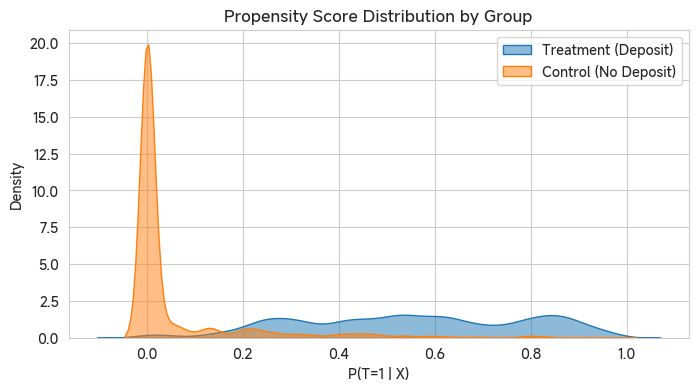

In [120]:
plt.figure(figsize=(8,4))
sns.kdeplot(df_ab.loc[t==1, "propensity"], label="Treatment (Deposit)", fill=True, alpha=0.5)
sns.kdeplot(df_ab.loc[t==0, "propensity"], label="Control (No Deposit)", fill=True, alpha=0.5)
plt.title("Propensity Score Distribution by Group")
plt.xlabel("P(T=1 | X)")
plt.ylabel("Density")
plt.legend()
plt.show()


### 🧩 Cell 4 — Weighted Model Training（加权双模型训练说明）

在这一单元中，我们训练两套独立的模型 `f1` 与 `f0`，分别用于估计个体在**有押金（treatment=1）**与**无押金（treatment=0）**情况下的取消概率。
#### 🎯 目的

* 建立**个体化反事实预测（individual counterfactual prediction）**；
* 用来计算每个客户的 uplift：
  $$
  \text{uplift} = P(\text{cancel} | \text{押金}) - P(\text{cancel} | \text{无押金})
  $$
#### ⚖️ 方法与加权逻辑

1. **f₁ 模型（treatment group）**

   * 在押金客户子集上训练；
   * 使用 `w_treat` 作为样本权重。
   * 权重来源于倾向得分逆概率加权 (IPW)，确保样本在特征空间上与对照组分布一致。
2. **f₀ 模型（control group）**

   * 在无押金客户子集上训练；
   * 使用 `w_ctrl` 作为样本权重。
   * 同样通过 IPW 调整，使模型学习到“如果这些样本在 treatment 状态下会如何表现”。
#### 🔍 模型配置
使用 **Gradient Boosting Classifier**（梯度提升分类器）：
* `n_estimators=200` → 控制弱学习器数量，保证模型复杂度；
* `learning_rate=0.05` → 防止过拟合；
* `max_depth=4` → 限制单棵树的深度；
* `random_state=42` → 保证可复现性。


In [103]:
# Cell 4 — Weighted Model Training
from sklearn.ensemble import GradientBoostingClassifier

f1 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05,
                                max_depth=4, random_state=42)
f0 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05,
                                max_depth=4, random_state=42)

# Weighted fitting
f1.fit(X[t == 1], y[t == 1], sample_weight=w_treat[t == 1])
f0.fit(X[t == 0], y[t == 0], sample_weight=w_ctrl[t == 0])

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, n_estimators=200,
                           random_state=42)

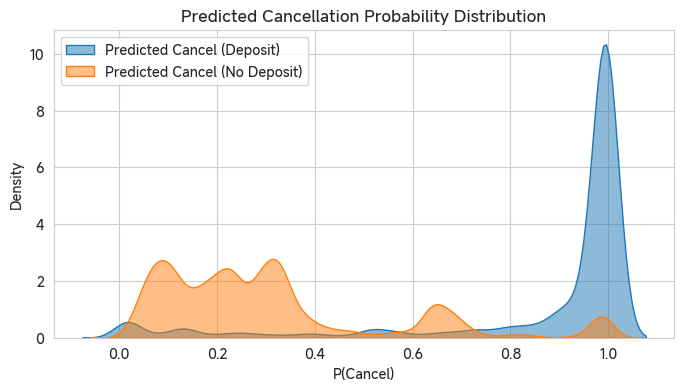

In [121]:
p1 = f1.predict_proba(X)[:, 1]
p0 = f0.predict_proba(X)[:, 1]

plt.figure(figsize=(8,4))
sns.kdeplot(p1, label="Predicted Cancel (Deposit)", fill=True, alpha=0.5)
sns.kdeplot(p0, label="Predicted Cancel (No Deposit)", fill=True, alpha=0.5)
plt.title("Predicted Cancellation Probability Distribution")
plt.xlabel("P(Cancel)")
plt.legend()
plt.show()


In [104]:
# Cell 4.1 — 模型正确率评估
from sklearn.metrics import accuracy_score

# 各自分组上的预测
pred1 = f1.predict(X[t == 1])
pred0 = f0.predict(X[t == 0])

acc1 = accuracy_score(y[t == 1], pred1)
acc0 = accuracy_score(y[t == 0], pred0)

print(f"🎯 f1（有押金组）模型训练准确率：{acc1:.4f}")
print(f"🎯 f0（无押金组）模型训练准确率：{acc0:.4f}")
print(f"平均模型准确率：{(acc1 + acc0) / 2:.4f}")


🎯 f1（有押金组）模型训练准确率：0.9977
🎯 f0（无押金组）模型训练准确率：0.7834
平均模型准确率：0.8906


In [92]:
# Cell 5 — 个体 uplift
p1 = f1.predict_proba(X)[:, 1]
p0 = f0.predict_proba(X)[:, 1]
uplift = p1 - p0

df_ab["uplift"] = uplift
df_ab[["uplift"]].describe()


,uplift
count,119390.000000
mean,0.556386
std,0.297094
min,-0.857674
25%,0.355203
50%,0.671476
75%,0.775299
max,0.989725


In [93]:
sum(df_ab['uplift'] > 0), len(df_ab)

(111340, 119390)

## 💡 押金高敏感客户，反而本身的取消率低。

### 🎯 策略：对于押金高敏感用户，在他们完成预订后——

* **不应再推送更优惠或替代性产品**。
  这类用户在心理上对押金高度敏感、风险厌恶，
  一旦预订后又接收到新的“更划算选择”，会产生**认知失调与选择后悔**，
  从而陷入反复比较 → 修改 → 取消的循环。

* **建议采取“静默成交”策略**：
  在他们完成下单后，不再触发追加优惠或交叉推荐，
  让其保持决策的封闭性与心理确定性，降低取消率。

* **押金政策可适度宽松或豁免**：
  因为模型显示他们即便不被强制约束，也极少取消。
  相反，免押金反而提升他们的信任度与满意度。
  对于高价值会员或提前规划型客户，可尝试「免押金—忠诚返还」等机制。


### 💼 对比策略：针对押金低敏感用户

* **这类人群“押金无感”，却更容易临时变动**。
  他们的高取消率不是因为押金存在，而是因为**预订动机弱、计划随意**。
  因此，应：

  * 收取全额押金或不可退预订；
  * 或采用「押金抵用消费」「押金锁定优惠」的金融型激励；
  * 明确取消成本，引导他们做出稳定承诺。



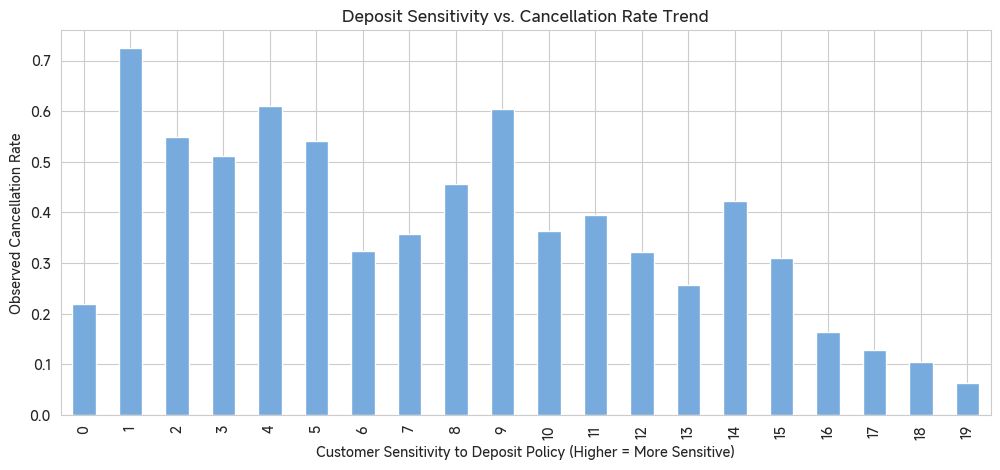

In [110]:
# # Cell 6 — uplift 排序分组
# df_ab["uplift_decile"] = pd.qcut(df_ab["uplift"], 20, labels=False)
# uplift_summary = df_ab.groupby("uplift_decile")["target"].mean()
# 
# plt.figure(figsize=(12, 5))
# uplift_summary.plot(kind="bar", color="#77aadd")
# plt.title("押金敏感度与取消率趋势图")
# plt.xlabel("对于是否有押金的敏感程度")
# plt.ylabel("取消率")
# plt.show()
# Cell 6 — Uplift Decile Grouping and Visualization
df_ab["uplift_decile"] = pd.qcut(df_ab["uplift"], 20, labels=False)
uplift_summary = df_ab.groupby("uplift_decile")["target"].mean()

plt.figure(figsize=(12, 5))
uplift_summary.plot(kind="bar", color="#77aadd")
plt.title("Deposit Sensitivity vs. Cancellation Rate Trend")
plt.xlabel("Customer Sensitivity to Deposit Policy (Higher = More Sensitive)")
plt.ylabel("Observed Cancellation Rate")
plt.show()


In [95]:
print(uplift_summary)

uplift_decile
0     0.218247
1     0.724338
2     0.549158
3     0.511803
4     0.609573
5     0.541731
6     0.324858
7     0.358131
8     0.456272
9     0.605225
10    0.363717
11    0.395597
12    0.321351
13    0.257614
14    0.423244
15    0.310333
16    0.164595
17    0.128018
18    0.104463
19    0.063151
Name: target, dtype: float64


In [96]:
# 验证：uplift高群体的 baseline 风险
df_ab["baseline_p0"] = f0.predict_proba(X)[:, 1]

high_uplift = df_ab[df_ab["uplift_decile"] >= 15]
low_uplift = df_ab[df_ab["uplift_decile"] <= 5]

print("High-uplift baseline cancel prob:", high_uplift["baseline_p0"].mean())
print("Low-uplift baseline cancel prob:", low_uplift["baseline_p0"].mean())


High-uplift baseline cancel prob: 0.1305792563378464
Low-uplift baseline cancel prob: 0.5131215846846816


💡 Empirical Finding
The uplift analysis reveals a strong inverse relationship between deposit sensitivity and baseline cancellation probability.
Customers predicted to be most affected by deposits (“high-uplift”) actually show the lowest observed cancellation rates.

🎯 Business Insight

Require deposits from low-sensitivity customers (they cancel more).

Waive deposits for high-sensitivity customers (they’re stable but dislike friction).

After high-sensitivity users book, avoid post-booking offers—they’re prone to overthinking, which can increase cancellation.

🔍 Interpretation
Deposit mechanisms serve as a selection filter, not a deterrent.
They separate stable, rational customers from flexible, impulsive ones.

In [122]:
!jupyter nbconvert --to html uplift_modelling.ipynb

[NbConvertApp] Converting notebook uplift_modelling.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 697896 bytes to uplift_modelling.html
